# Proyecto entrega 1

### Integrantes
* Santiago Gomez
* Sebastian Martinez
* Johan Suarez

### Grupo
36

## Carga de datos

In [33]:
%pip install -U "spacy>=3.8,<3.9"
%pip install "./es_core_news_sm-3.8.0-py3-none-any.whl" 

Note: you may need to restart the kernel to use updated packages.
Processing c:\users\santi\onedrive\escritorio\universidad\2025\2025-2\bi\proyecto-1\es_core_news_sm-3.8.0-py3-none-any.whl
es-core-news-sm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

vectorizer = TfidfVectorizer()
nlp = spacy.load("es_core_news_sm")
dfOriginal = pd.read_excel('Datos_proyecto.xlsx')
dfOriginal.info()
targetNames = dfOriginal['labels'].unique()
print("Categorías encontradas:", targetNames)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB
Categorías encontradas: [4 3 1]


## Exploración del texto

Principalmente observemos el formato inicial del dataset, con especial enfasis en la columna de textos

In [35]:
targetNames =  {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
dfOriginal.head()
df = dfOriginal.copy()
df['textos'] = df['textos'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


### Exploracion de longitudes de los textos presentados en el dataset

In [36]:
def columnasConteo(df : pd.DataFrame):
    df['Conteo'] = [len(x) for x in df['textos']]
    df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['textos']]
    df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['textos']]
columnasConteo(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0


Veamos ahora los maximos, minimos y promedio de la longitud de los textos del dataset

In [37]:
def longitud(df: pd.DataFrame):
    maximo = df['Conteo'].max()
    minimo = df['Conteo'].min()
    promedio = int(df['Conteo'].mean())
    print(f'El maximo de longitud es: {maximo}')
    print(f'El minimo de longitud es: {minimo}')
    print(f'El promedio de longitud es: {promedio:.2f}')
    return maximo, minimo, promedio

El maximo de longitud es: 1492
El minimo de longitud es: 303
El promedio de longitud es: 683.00


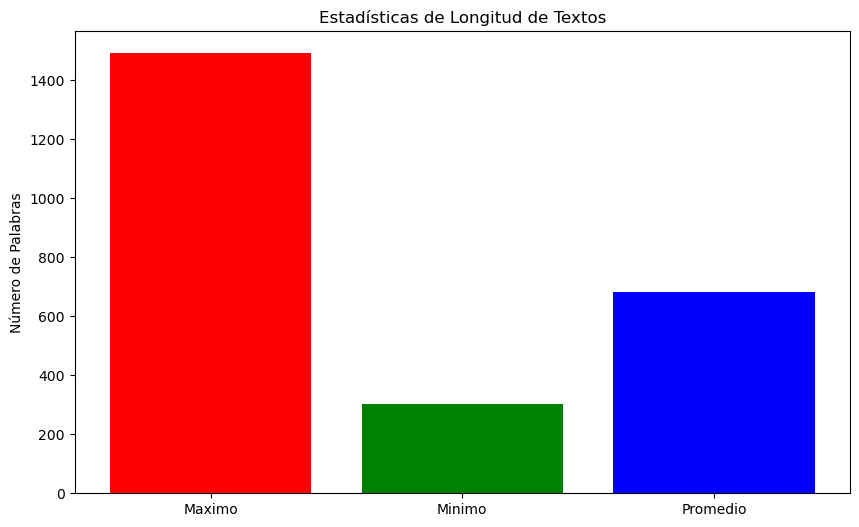

In [38]:
maximo, minimo, promedio = longitud(df)
plt.figure(figsize=(10,6))
plt.bar(['Maximo', 'Minimo', 'Promedio'], [maximo, minimo, promedio], color=['red', 'green', 'blue'])
plt.title('Estadísticas de Longitud de Textos')
plt.ylabel('Número de Palabras')
plt.show()


### Distribucion de la longitud

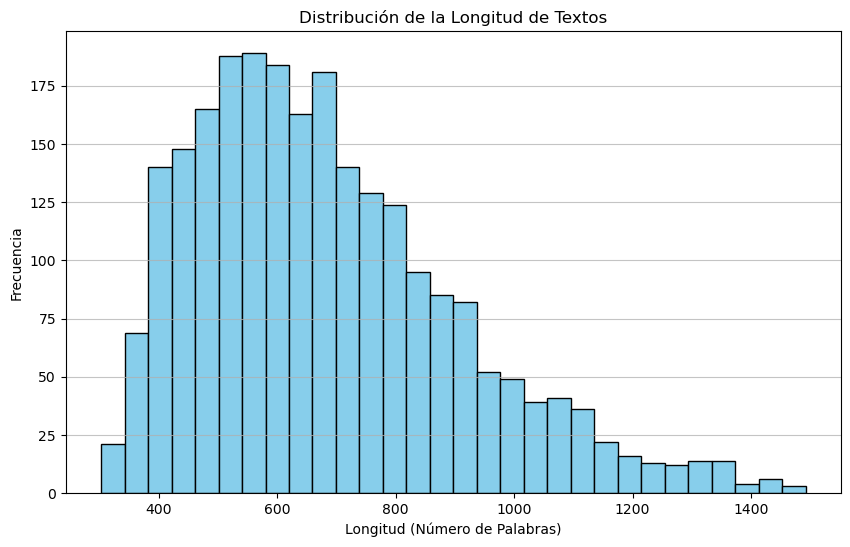

In [39]:

plt.figure(figsize=(10,6))
plt.hist(df['Conteo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de Textos')
plt.xlabel('Longitud (Número de Palabras)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

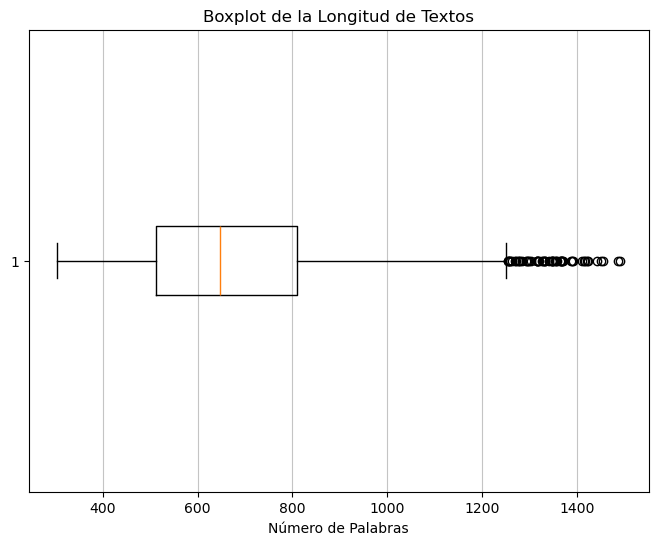

In [40]:
#Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(df['Conteo'], vert=False)
plt.title('Boxplot de la Longitud de Textos')
plt.xlabel('Número de Palabras')
plt.grid(axis='x', alpha=0.75)
plt.show()

### Presencia de catracteres especiales

In [41]:
def especiales(df : pd.DataFrame):
    signos = r"(?:[!¡¿?;:'\"]|\.{3})"
    signosPresentes = df['textos'].str.contains(signos).sum()
    print(f'La cantidad de textos con signos de puntuación es: {signosPresentes}')
    print(f'El porcentaje de textos con signos de puntuación es: {signosPresentes/len(df)*100:.2f}%')
    especiales = r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])"
    especialesPresentes = df['textos'].str.contains(especiales).sum()
    print(f'La cantidad de textos con caracteres especiales es: {especialesPresentes}')
    print(f'El porcentaje de textos con caracteres especiales es: {especialesPresentes/len(df)*100:.2f}%')
    return signosPresentes, especialesPresentes


La cantidad de textos con signos de puntuación es: 596
El porcentaje de textos con signos de puntuación es: 24.59%
La cantidad de textos con caracteres especiales es: 1562
El porcentaje de textos con caracteres especiales es: 64.44%


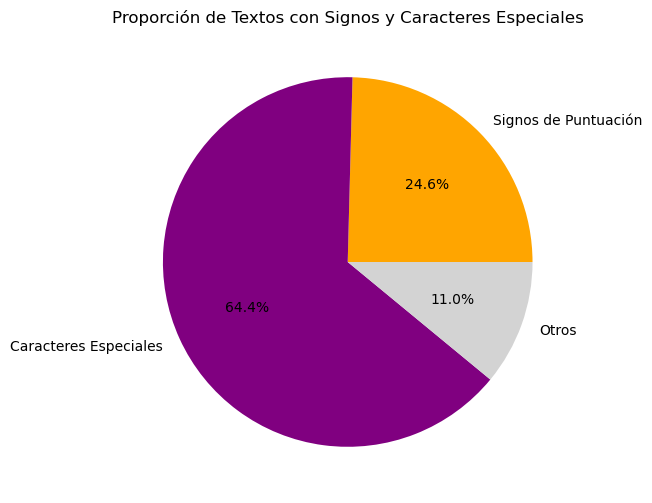

In [42]:
#Distribucion especiales
size = df['textos'].size
signosPresentes, especialesPresentes = especiales(df)
plt.figure(figsize=(8,6))
plt.pie([signosPresentes, especialesPresentes, size - signosPresentes - especialesPresentes], labels=['Signos de Puntuación', 'Caracteres Especiales', 'Otros'], autopct='%1.1f%%', colors=['orange', 'purple', 'lightgray'])
plt.title('Proporción de Textos con Signos y Caracteres Especiales')
plt.show()


### Distribucion de labels

,conteo
ODS 1,505
ODS 3,894
ODS 4,1025


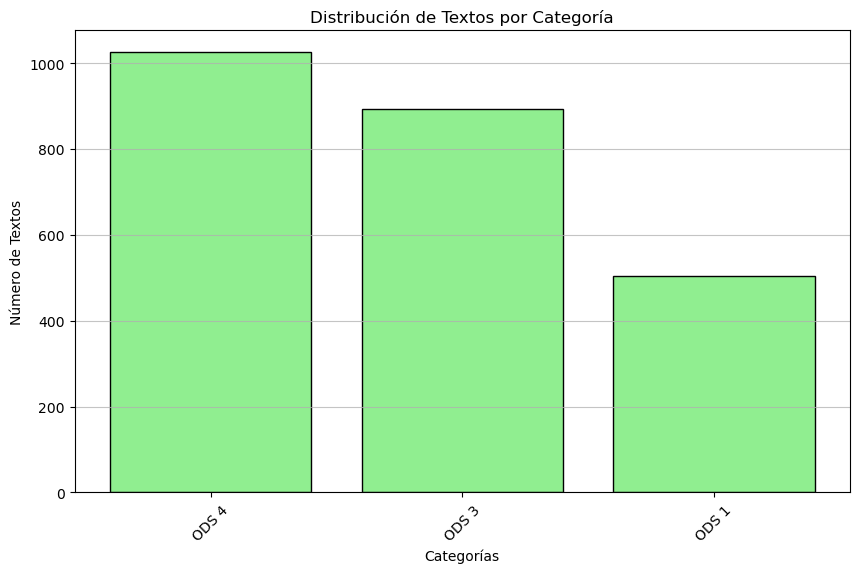

In [43]:
tiposComentario = df['labels'].value_counts().sort_index()
tiposComentario.index = [targetNames[i] for i in tiposComentario.index]
display(tiposComentario.to_frame('conteo'))

labelContador = df['labels'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(labelContador.index.map(targetNames), labelContador.values, color='lightgreen', edgecolor='black')
plt.title('Distribución de Textos por Categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


<Figure size 1000x600 with 0 Axes>

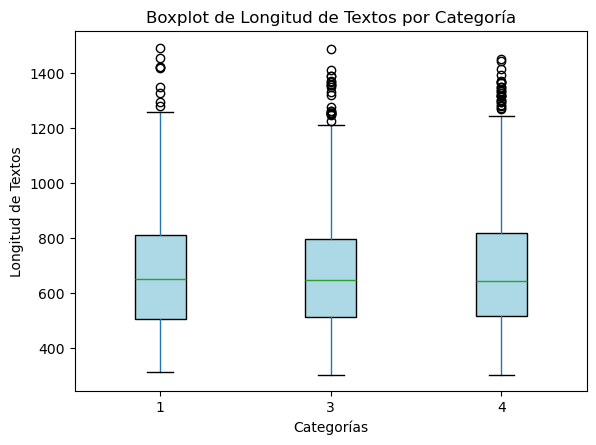

In [44]:
#Boxplot por categoria
plt.figure(figsize=(10,6))
df.boxplot(column='Conteo', by='labels', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Longitud de Textos por Categoría')
plt.suptitle('')  
plt.xlabel('Categorías')
plt.ylabel('Longitud de Textos')
plt.show()

### Limpieza

Procedemos a poner todo el dataset en un único formato

In [45]:
def todoAmin(df: pd.DataFrame):
    df['textos'] = df['textos'].str.lower()
todoAmin(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"además, la formación de especialistas en medic...",3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


Limpieza de caracteres especiales, signos y urls

In [46]:
def limpiza(df: pd.DataFrame):
    df['textos'] = df['textos'].str.replace(r"http[s]?://[^\s)]+", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[!¡¿?;:'\".,]|\.{3})", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"\s+", ' ', regex=True).str.strip()
limpiza(df)
df.head()


,textos,labels,Conteo,Max,Min
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1
2,además la formación de especialistas en medici...,3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


### Duplicados y Nulos

In [47]:
#Codigo dado en el notebook de la clase
def verNulosYDuplicados(df: pd.DataFrame):
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    print("\nDuplicados (filas completas):", df.duplicated().sum())
    const_cols = [c for c in df.columns if df[c].nunique() == 1]
    print("Columnas constantes:", const_cols if const_cols else "Ninguna")
verNulosYDuplicados(df)

Valores nulos por columna:


textos    0
labels    0
Conteo    0
Max       0
Min       0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


### Tokenización

In [48]:
def tokenizacion(df: pd.DataFrame):
    columnaTokens = []
    for opinion in df['textos']:
        columnaTokens.append(opinion.split())
    df['tokens'] = columnaTokens
    return df
doc = tokenizacion(df)   
df.head()

,textos,labels,Conteo,Max,Min,tokens
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q..."


### Eliminación de tockens innecesarios, articulos, preposiciones, etc.

In [49]:
def quitar_stopwords(df: pd.DataFrame):
    stopwords = nlp.Defaults.stop_words
    tokensSinStopwords = []
    
    for lista in df['tokens']:
        tokens_filtrados = [tok for tok in lista if tok.lower() not in stopwords]
        tokensSinStopwords.append(tokens_filtrados)

    df['tokens_sin_innecesarios'] = tokensSinStopwords

quitar_stopwords(df)
df.head()


,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


### Lematización

In [50]:
def lematizar_tokens(df: pd.DataFrame):
    lemas = []
    for lista in df['tokens_sin_innecesarios']:

        texto = " ".join(lista)
        doc = nlp(texto)
        lemas.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    df['lematizados'] = lemas
    return df

df = lematizar_tokens(df)
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


### Analisis de frecuencia de palabras

In [51]:
def frecuenciasPorPalabra(df: pd.DataFrame, vectorizer=vectorizer):
    textos = [" ".join(tokens) for tokens in df['lematizados']]
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    pesosPromedio = np.asarray(X.mean(axis=0)).ravel()
    freq_df = pd.DataFrame({'Palabra': palabras, 'Peso Promedio': pesosPromedio})
    freq_df = freq_df.sort_values(by='Peso Promedio', ascending=False).reset_index(drop=True)
    return freq_df

freq_df = frecuenciasPorPalabra(df)
freq_df.head(10)


,Palabra,Peso Promedio
0,salud,0.027882
1,educación,0.025477
2,país,0.025256
3,escuela,0.024556
4,atención,0.024052
5,pobreza,0.022993
6,sistema,0.018521
7,año,0.018438
8,nivel,0.018389
9,servicio,0.017348


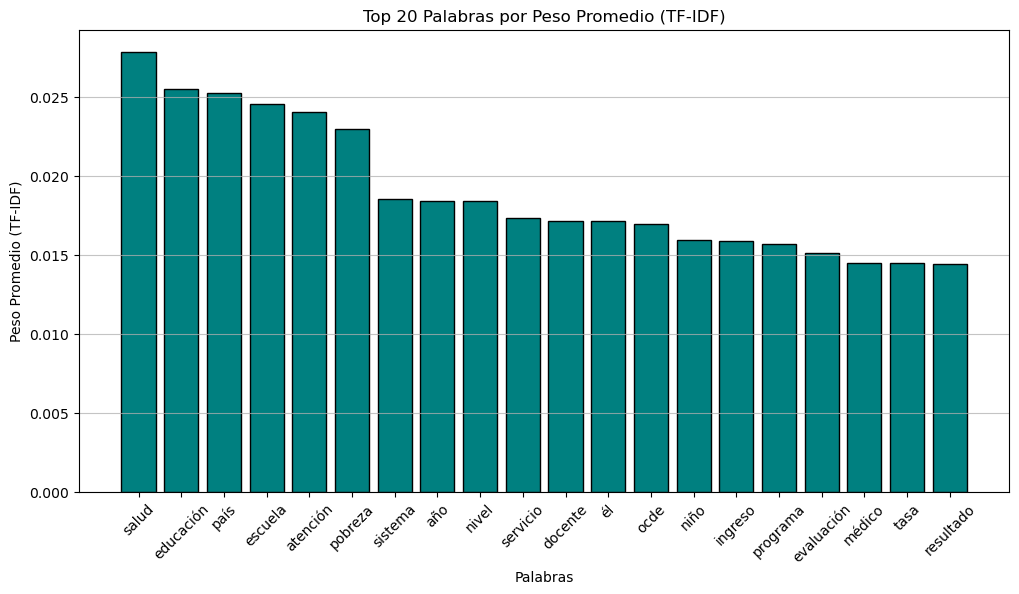

In [52]:
#plot frecuencias
plt.figure(figsize=(12,6))
plt.bar(freq_df['Palabra'][:20], freq_df['Peso Promedio'][:20], color='teal', edgecolor='black')
plt.title('Top 20 Palabras por Peso Promedio (TF-IDF)')
plt.xlabel('Palabras')
plt.ylabel('Peso Promedio (TF-IDF)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [53]:

def redNeuronal(textos, labels):
    XTrain, XTest, yTrain, yTest = train_test_split(
        textos, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    vectorizer = TfidfVectorizer(
        max_features=3000,
        min_df=2,
        max_df=0.8,
        ngram_range=(1, 2)
    )
    XTrain = vectorizer.fit_transform(XTrain)
    XTest  = vectorizer.transform(XTest)

    red = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', random_state=42)
    red.fit(XTrain, yTrain)

    yPred  = red.predict(XTest)
    yProba = red.predict_proba(XTest)

    return red, vectorizer, XTrain, XTest, yTrain, yTest, yPred, yProba

textos = [" ".join(t) for t in df['lematizados']]
red, vectorizer, XTrain, XTest, yTrain, yTest, yPred, yProba = redNeuronal(textos, df['labels'])


In [54]:

def imprimir_metricas_simple(yTrue, yPred, yProba):
    acc = accuracy_score(yTrue, yPred)
    if yProba.shape[1] == 2:
        roc = roc_auc_score(yTrue, yProba[:, 1])
        roc_txt = f"ROC AUC: {roc:.4f}"
    else:
        roc = roc_auc_score(yTrue, yProba, multi_class="ovr", average="macro")
        roc_txt = f"ROC AUC: {roc:.4f}"

    print(f"Accuracy: {acc:.4f}\n{roc_txt}\n")
    print(classification_report(yTrue, yPred, digits=4))

imprimir_metricas_simple(yTest, yPred, yProba)

Accuracy: 0.9588
ROC AUC: 0.9959

              precision    recall  f1-score   support

           1     0.9495    0.9307    0.9400       101
           3     0.9661    0.9553    0.9607       179
           4     0.9569    0.9756    0.9662       205

    accuracy                         0.9588       485
   macro avg     0.9575    0.9539    0.9556       485
weighted avg     0.9588    0.9588    0.9587       485



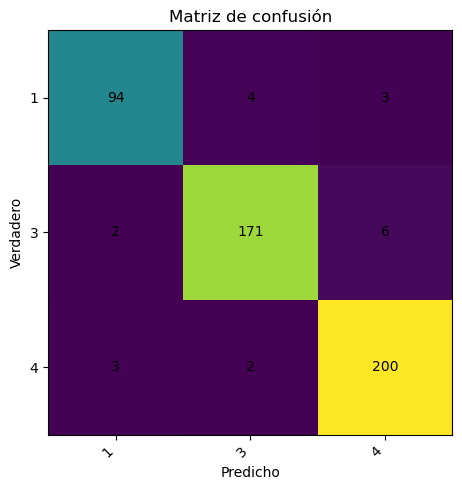

In [55]:
def plot_confusion(yTrue, yPred, classes):
    cm = confusion_matrix(yTrue, yPred, labels=classes)
    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión")
    plt.xticks(np.arange(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(np.arange(len(classes)), classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.tight_layout()
    plt.show()

plot_confusion(yTest, yPred, red.classes_)

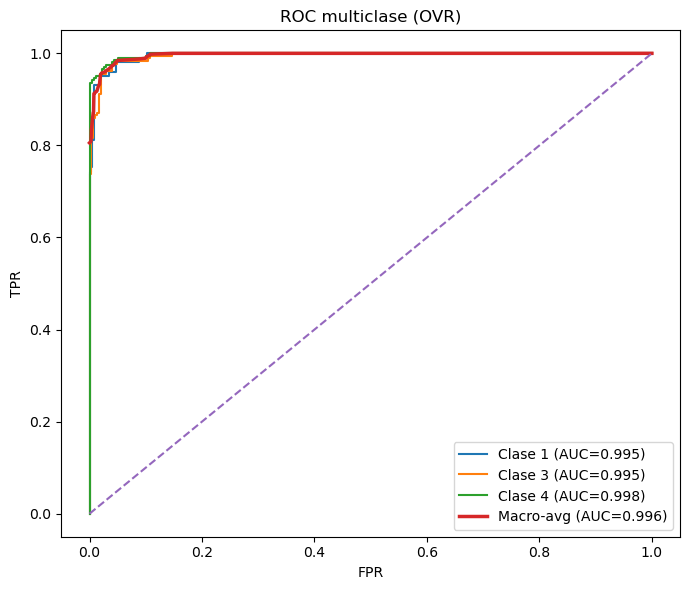

In [56]:
def plotRocCurves(yTrue, yProba, clases):
    clases = np.array(list(clases))
    nClases = len(clases)

    yTrueB = label_binarize(yTrue, classes=clases)
    fprDict, tprDict, aucDict = {}, {}, {}

    for i, c in enumerate(clases):
        fprDict[i], tprDict[i], _ = roc_curve(yTrueB[:, i], yProba[:, i])
        aucDict[i] = auc(fprDict[i], tprDict[i])

    allFpr = np.unique(np.concatenate([fprDict[i] for i in range(nClases)]))
    meanTpr = np.zeros_like(allFpr)
    for i in range(nClases):
        meanTpr += np.interp(allFpr, fprDict[i], tprDict[i])
    meanTpr /= nClases
    macroAuc = auc(allFpr, meanTpr)

    fig = plt.figure(figsize=(7, 6))
    for i, c in enumerate(clases):
        plt.plot(fprDict[i], tprDict[i], label=f"Clase {c} (AUC={aucDict[i]:.3f})")
    plt.plot(allFpr, meanTpr, linewidth=2.5, label=f"Macro-avg (AUC={macroAuc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC multiclase (OVR)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plotRocCurves(yTest, yProba, red.classes_)


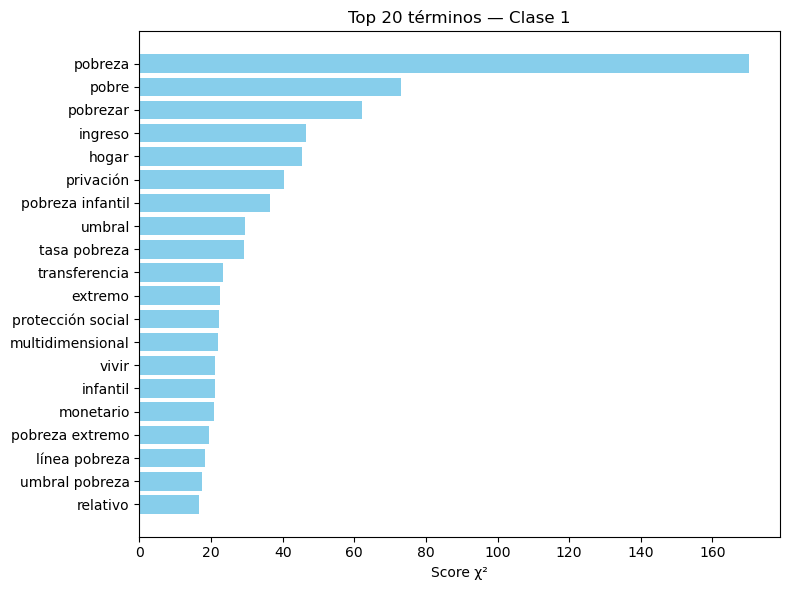

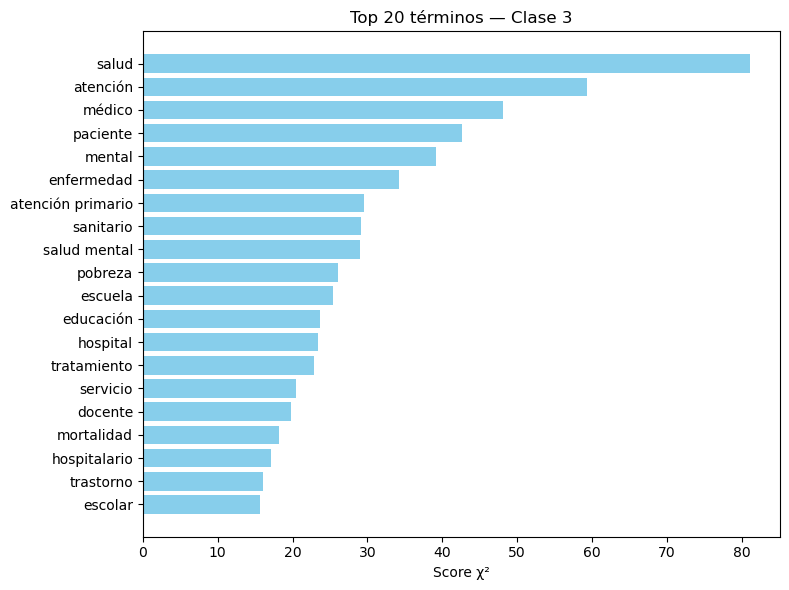

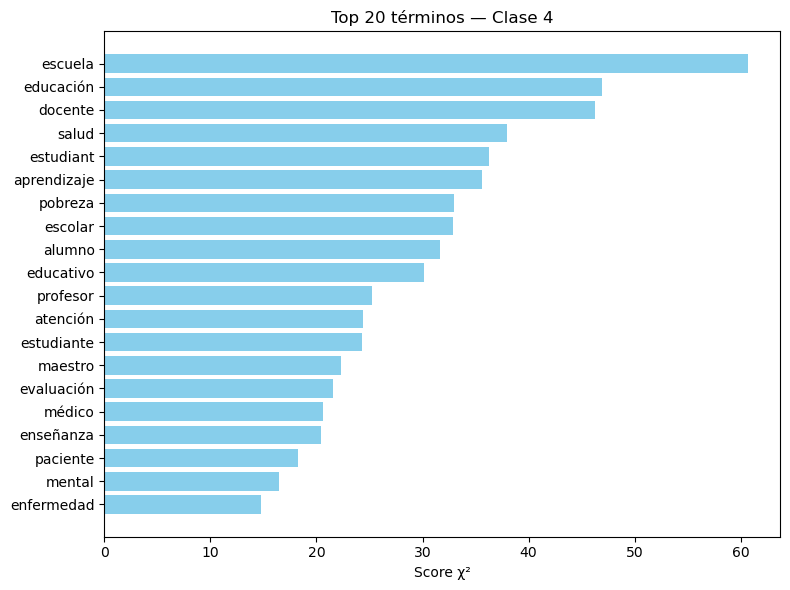

In [57]:
def plotTopTermsChi2(XTrain, yTrain, vectorizer, clases, k=20):
    featNames = np.array(vectorizer.get_feature_names_out())
    clases = np.array(list(clases))

    for c in clases:
        yBin = (yTrain == c).astype(int)
        scores, _ = chi2(XTrain, yBin)
        
        orden = np.argsort(scores)[::-1]
        ordenValid = [idx for idx in orden if np.isfinite(scores[idx])]
        topIdx = ordenValid[:k]

        topTerms = featNames[topIdx]
        topScores = scores[topIdx]

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(topTerms)), topScores, color="skyblue")
        plt.yticks(range(len(topTerms)), topTerms)
        plt.gca().invert_yaxis()  
        plt.title(f"Top {k} términos — Clase {c}")
        plt.xlabel("Score χ²")
        plt.tight_layout()
        plt.show()

plotTopTermsChi2(XTrain, yTrain, vectorizer, red.classes_, k=20)